### Creating data points for testing Clustering 

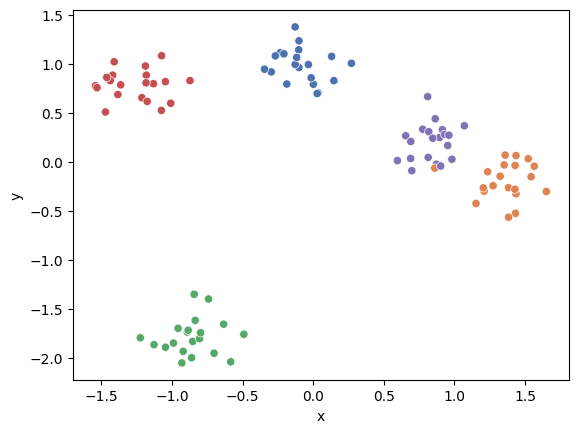

In [193]:
from __future__ import annotations # To prevent Subscript for class "list" will generate runtime exception; enclose type annotation in quotes
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
centers = 5
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels,
                palette="deep",
                legend=None
                )
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### KMeans algorithm

In [5]:
# class KMeans:
#     def __init__(self, n_clusters=8, max_iter=300):
#         self.n_clusters = n_clusters
#         self.max_iter = max_iter
#     def fit(self, X_train):
#         # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
#         # then the rest are initialized w/ probabilities proportional to their distances to the first
#         # Pick a random point from train data for first centroid
#         self.centroids = np.array([random.choice(X_train)])
#         print(self.centroids)
#         for _ in range(self.n_clusters-1):
#             # Calculate distances from points to the centroids
#             dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
#             # Normalize the distances
#             dists /= np.sum(dists)
#             # Choose remaining points based on their distances
#             new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
#             self.centroids += np.array([X_train[new_centroid_idx]])
#         # This initial method of randomly selecting centroid starts is less effective
#         # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
#         # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
#         # Iterate, adjusting centroids until converged or until passed max_iter
#         iteration = 0
#         prev_centroids = None
#         while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
#             # Sort each datapoint, assigning to nearest centroid
#             sorted_points = [[] for _ in range(self.n_clusters)]
#             for x in X_train:
#                 dists = euclidean(x, self.centroids)
#                 centroid_idx = np.argmin(dists)
#                 sorted_points[centroid_idx].append(x)
#             # Push current centroids to previous, reassign centroids as mean of the points belonging to them
#             prev_centroids = self.centroids
#             # print(prev_centroids)
#             self.centroids = np.array([np.mean(cluster, axis=0) for cluster in sorted_points])
#             for i, centroid in enumerate(self.centroids):
#                 if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
#                     # print(self.centroids[i-1])
#                     # print(prev_centroids[i-1])
#                     self.centroids[i] = prev_centroids[i-1]
#             iteration += 1
#     def evaluate(self, X):
#         centroids = []
#         centroid_idxs = []
#         for x in X:
#             dists = euclidean(x, self.centroids)
#             centroid_idx = np.argmin(dists)
#             centroids.append(self.centroids[centroid_idx])
#             centroid_idxs.append(centroid_idx)
#         return centroids, centroid_idxs

In [194]:
def eucledian_distance(x1,x2) :
  return np.sqrt(np.sum((x1-x2)**2)) #vector based

def minkowski_distance(x1,x2,p):
  from scipy.spatial import distance
  return distance.minkowski(x1,x2,p)

class Kmeans:
  #K = number of clusters
  #iter = number of iterations
  def __init__(self,K,iter,p):
    self.K=K
    self.iter=iter
    self.p=p
    #Initialising empty K clusters -> storing indicies
    self.clusters = [[] for _ in range(self.K)] 
    #storing centroids 
    self.centroids=[]
    self.inertia = 0.0 

  def plus_plus(self,ds:np.array, k, random_state=1000):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

  '''def random(self,ds, k, random_state=42):
    """
    Create random cluster centroids.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    np.random.seed(random_state)
    centroids = []
    m = np.shape(ds)[0]

    for _ in range(k):
        r = np.random.randint(0, m-1)
        centroids.append(ds[r])

    return np.array(centroids)'''

  def naive_sharding(self,ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    def _get_mean(sums, step):
        """Vectorizable ufunc for getting means of summed shard columns."""
        return sums/step

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.zeros((k, n))

    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    step = math.floor(m/k)
    vfunc = np.vectorize(_get_mean)

    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids
  
  def predict(self,X,choice=0): #no fit required for unsupervised learning models
    self.X=X
    self.n_samples,self.n_features = X.shape #numpy N-d array
    
    #initialise centroids
    if choice == 0:
      np.random.seed(42)
      random_sample_idx = np.random.choice(self.n_samples,self.K,replace=False)
      self.centroids = [self.X[idx] for idx in random_sample_idx]
    elif choice == 1:
      self.centroids=self.plus_plus(X,self.K)
      # print(self.centroids)
    elif choice == 2:
      self.centroids=self.naive_sharding(X,self.K)
    

    #optimise 
    for _ in range(self.iter):
      #update clusters
      self.clusters=self._create_clusters(self.centroids)

      #update centroids 
      centroids_old = self.centroids #for convergence test 
      self.centroids = self._get_centroids(self.clusters)
       #get cetnroids assign mean value of cluster to the centroid
      #check for convergence
      if self._isConverged(centroids_old,self.centroids):
        break

      #break 
    #classify the samples based on index of cluster
    labels = self.getClusterLabels(self.clusters)
    self.calculateInertia(X,labels)
    return labels
    #return cluster labels 
  def _create_clusters(self,centroids):
    clusters = [[] for _ in range(self.K)]
    for idx,sample in enumerate(self.X):
      #find the closest centroid to classify, then put it in the specific cluster
      #here cluster is an list of list 
      centroid_idx = self._closest_centroid(sample,centroids)
      clusters[centroid_idx].append(idx)
    return clusters
  def function (self,point):
    return minkowski_distance(self.sample, point, self.p)

  def _closest_centroid(self,sample,centroids):
    #distance metric  
    distances = [minkowski_distance(sample,point,self.p) for point in centroids]
    #argmin for required parameters
    closest_idx = np.argmin(distances)
    # self.sample=sample
    # closest_idx = scipy.optimize.minimize (fun=function ,x0=np.asarray(centroids))
    return closest_idx
  def _get_centroids(self,clusters):
    centroids = np.zeros((self.K,self.n_features)) #Dimension = N as N = number of features
    for cluster_idx, cluster in enumerate(clusters):
      #calling mean on a specific current cluster as X is array of various clusters
      cluster_mean = np.mean(self.X[cluster],axis = 0)
      centroids[cluster_idx] = cluster_mean #set mean as newer centroids
    return centroids 
  def _isConverged(self,centroids_old,centroids):
    distances = [minkowski_distance(centroids_old[i],centroids[i],self.p) for i in range(self.K)]
    return sum(distances)==0 #no more change occured in 2 iteration so converges 

  def getClusterLabels(self,clusters):
    labels = np.empty(self.n_samples)
    for cluster_idx,cluster in enumerate(clusters):
      for sample_idx in cluster:
        labels[sample_idx] = cluster_idx
    return labels 
  
  def calculateInertia(self,datapoints: list[int],labels: list[any])->None:
    labels = labels.astype(int)
    for idx,pts in enumerate(datapoints):
      self.inertia += minkowski_distance(self.centroids[labels[idx]],pts,2)
    
  def plot(self):
    #using matplot lib
    fig,ax = plt.subplots(figsize=(16,10))
    for i, index in enumerate(self.clusters):
      point = self.X[index].T
      ax.scatter(*point)
    for point in self.centroids:
      #market is for centroid 
      ax.scatter(*point,marker = "x", color = "black" , linewidth = 2) #* is used to unfold a point
    plt.show()


### Testing on generated datapoints

In [195]:
df=pd.read_excel('Course Recommendation System.xlsx')
df=df.drop(['ID','Start time','Completion time','Email','Name','Name(not mandatory)\n' ], axis=1).fillna(0.5)
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,Digital CMOS VLSI Design,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,0.50,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.5,0.5,0.5
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.4,0.5,0.5,0.5
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.8,0.5,0.5,0.8,0.5
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60,0.50,0.30,0.70,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5,0.5
158,1.00,0.00,0.00,0.70,0.70,0.00,0.00,0.00,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.2
159,0.60,0.30,0.40,0.90,0.80,0.70,0.40,0.50,0.4,0.2,...,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5,1.0
160,0.80,0.60,0.20,0.40,0.70,0.70,0.80,0.50,0.5,0.7,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [196]:
type(df)

pandas.core.frame.DataFrame

In [197]:
x=df[df.columns[0]]
y=df[df.columns[1]]
print(len(x))
print(len(y))

162
162


In [198]:
# df=df.to_numpy()
# np.shape(df[:,:2])
df=df[[df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4]]]
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2
0,0.30,0.85,0.85,0.90,0.70
1,0.70,0.80,0.20,0.80,0.80
2,0.70,0.00,1.00,1.00,1.00
3,0.65,0.70,0.20,0.75,0.75
4,0.70,0.60,0.20,0.00,0.80
...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60
158,1.00,0.00,0.00,0.70,0.70
159,0.60,0.30,0.40,0.90,0.80
160,0.80,0.60,0.20,0.40,0.70


#### Trial Run 

In [199]:
k=Kmeans(K=6,iter=150,p=2)
y_pred=k.predict(np.array(df),choice=1)
k.centroids=np.array(k.centroids, dtype='int')
len(k.centroids)
y_pred

array([0., 3., 2., 3., 4., 0., 1., 3., 5., 1., 5., 0., 1., 5., 5., 3., 5.,
       5., 5., 5., 3., 5., 2., 5., 5., 5., 2., 4., 4., 4., 4., 0., 4., 0.,
       5., 4., 5., 5., 1., 1., 3., 5., 3., 5., 3., 5., 5., 4., 0., 0., 3.,
       5., 1., 5., 5., 3., 1., 5., 5., 3., 2., 3., 5., 5., 3., 5., 1., 3.,
       5., 5., 5., 3., 0., 1., 3., 3., 5., 5., 3., 0., 4., 5., 1., 1., 4.,
       5., 0., 5., 0., 4., 1., 4., 5., 2., 2., 0., 5., 5., 4., 2., 0., 4.,
       3., 5., 1., 1., 0., 5., 2., 3., 1., 2., 0., 5., 2., 2., 5., 0., 2.,
       5., 4., 5., 0., 1., 5., 5., 1., 0., 5., 5., 5., 5., 4., 5., 1., 4.,
       4., 5., 5., 5., 1., 5., 4., 5., 5., 5., 5., 3., 5., 5., 5., 4., 4.,
       0., 3., 0., 2., 0., 3., 3., 4., 0.])

#### Elbow plot 

In [267]:
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = Kmeans(K=k,iter=10,p=2)
    kmeanModel.predict(np.array(df),choice=1)
    distortions.append(kmeanModel.inertia)
distortions

[106.38762190761003,
 93.71176283718019,
 84.72419812330908,
 77.56695962249968,
 73.68361740424038,
 72.38342303982998,
 70.96440587141502,
 66.7304456973877,
 63.54927557107264,
 60.43570525199548,
 57.455242656749604,
 54.574085165234806,
 55.13532480953998,
 54.13258385545006,
 52.41306514384238,
 51.123981051522044,
 47.94582195691944,
 45.84255367974844,
 44.54596985713616,
 43.08896217857829,
 42.58681870765173,
 42.06665925322221,
 42.13115733381227,
 41.22805972891417,
 41.35960317172211,
 41.17850090738687,
 39.69184752480758,
 38.1425120473632,
 37.661453794467754,
 37.16988865882814,
 36.66988865882814,
 35.51150126595995,
 34.963373569996946,
 34.26434056788681,
 33.54593113241322,
 33.145571593788425,
 32.43142875093414,
 31.45597250246028,
 30.52861065291071]

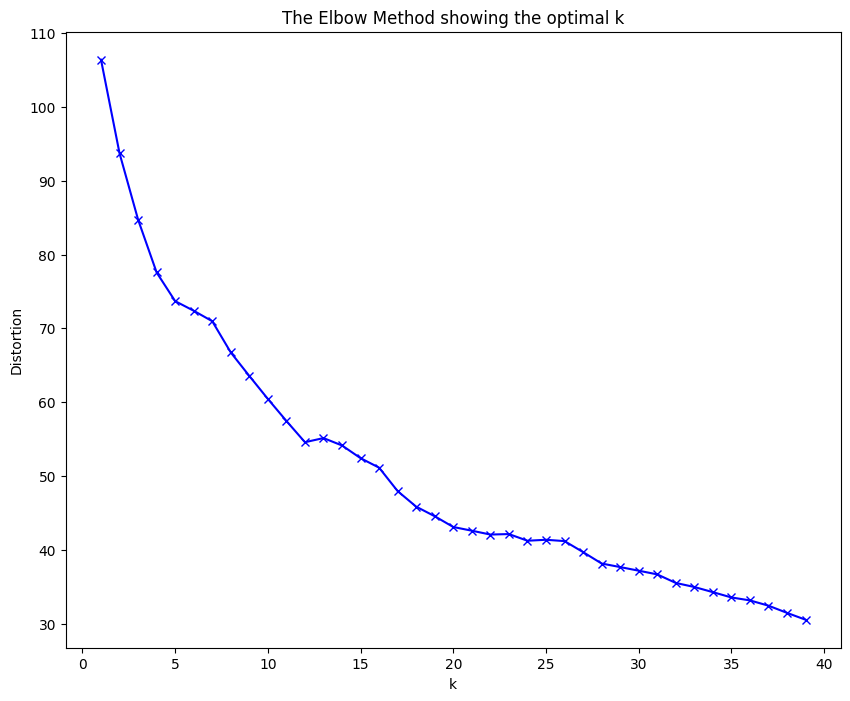

In [268]:
plt.figure(figsize=(10,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [269]:
df_temp = pd.DataFrame(pd.np.column_stack([df, y_pred]))
df_temp

/tmp/ipykernel_933/4165813272.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_temp = pd.DataFrame(pd.np.column_stack([df, y_pred]))


,0,1,2,3,4,5
0,0.30,0.85,0.85,0.90,0.70,0.0
1,0.70,0.80,0.20,0.80,0.80,3.0
2,0.70,0.00,1.00,1.00,1.00,2.0
3,0.65,0.70,0.20,0.75,0.75,3.0
4,0.70,0.60,0.20,0.00,0.80,4.0
...,...,...,...,...,...,...
157,0.00,1.00,0.50,0.70,0.60,0.0
158,1.00,0.00,0.00,0.70,0.70,3.0
159,0.60,0.30,0.40,0.90,0.80,3.0
160,0.80,0.60,0.20,0.40,0.70,4.0


/tmp/ipykernel_933/1378902715.py:5: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=df_temp[df_temp.columns[0]],y=df_temp[df_temp.columns[1]],hue=y_pred,palette=sns.color_palette("hls",10),data=df,


<AxesSubplot:xlabel='0', ylabel='1'>

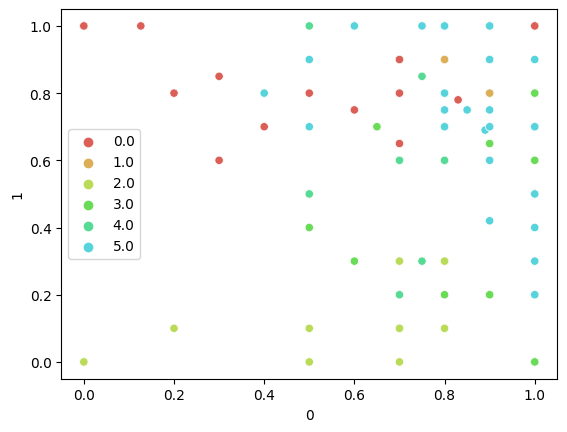

In [270]:
df_temp[df_temp.columns[2]]=y_pred
df_temp[df_temp.columns[0]]=x
df_temp[df_temp.columns[1]]=y

sns.scatterplot(x=df_temp[df_temp.columns[0]],y=df_temp[df_temp.columns[1]],hue=y_pred,palette=sns.color_palette("hls",10),data=df,
               legend="full")

In [271]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
# karan = KMeans(n_clusters=k)

wcss = []  #Within Cluster Sum of Squares
for k in range(1, 8): 
    kmeans = Kmeans(K=k,iter=10,p=2)
    kmeans.predict(np.array(df),choice=1)
    wcss.append(kmeans.inertia)
wcss


# distortions = []
# K = range(1,10)
# for k in K:
#     kmeanModel = Kmeans(K=k,iter=1000,p=2)
#     kmeanModel.predict(np.array(df),choice=1)
#     distortions.append(kmeanModel.inertia)
# distortions


[106.38762190761003,
 93.71176283718019,
 84.72419812330908,
 77.56695962249968,
 73.68361740424038,
 72.38342303982998,
 70.96440587141502]

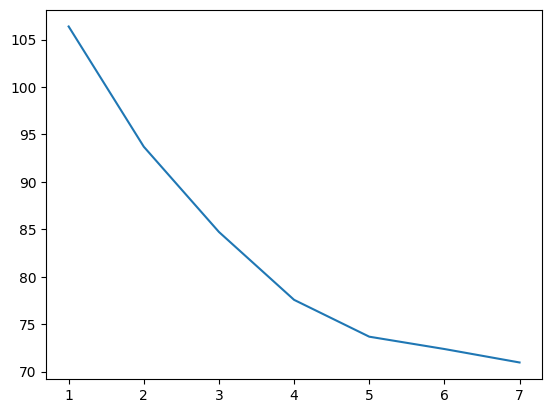

In [272]:
ks = [1, 2, 3, 4, 5 , 6 , 7 ]
plt.plot(ks, wcss)

In [273]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
core_courses = ['Data Structures and Algorithms','Computer Architecture\n','Discrete Mathematics\n','Economics','Programming-2']
wcss = []  #Within Cluster Sum of Squares
for number_of_clusters in range(1, 40): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(df[core_courses]) 
    wcss.append(kmeans.inertia_)
    print(kmeans.n_iter_)
wcss


2
5
8
5
8
9
4
11
13
6
7
7
5
15
8
8
5
6
10
7
6
5
12
9
7
6
4
5
9
9
5
4
6
4
8
3
5
6
5


[82.11226015529864,
 63.24078648485308,
 51.758327711871004,
 44.96053632709337,
 39.893986878723226,
 36.14482368312088,
 33.39870202326004,
 30.569535969351204,
 28.142142856387903,
 25.495720837938926,
 24.303521924994463,
 22.250775245363172,
 21.265056428481255,
 19.718577365314605,
 18.435442201490638,
 17.65333218736064,
 16.79336135658992,
 15.872098856494988,
 15.14767076436653,
 14.040403765307069,
 13.287484645020495,
 12.810795376845554,
 12.400001309597442,
 11.868933850806235,
 11.08817422626411,
 10.712303764079236,
 10.333856308642515,
 10.238303946543828,
 9.90169252712991,
 9.349028262424028,
 9.17781686695675,
 8.681846663238897,
 8.74507378068587,
 8.360433154761905,
 7.986850222490105,
 7.553415265225148,
 7.473501905598702,
 7.2468212635454075,
 7.164956028530469]

In [274]:
kmeans.n_iter_

5

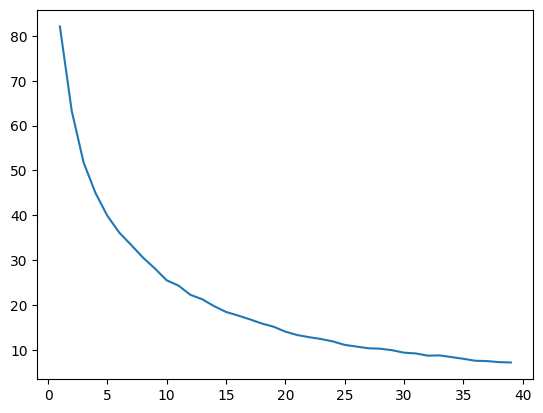

In [275]:
ks = [x for x in range(1,40)]
plt.plot(ks, wcss)